<div style="background-color: #103778; 
            color: white; 
            padding: 10px; 
            text-align: center;
            font-size: 20px;">
    <h1>PARTE I</h1>
</div>

# Introdução
Este conjunto de dados abrangente que oferece uma ampla gama de informações relacionadas a vendas no varejo online fornece uma análise detalhada de transações, detalhes de produtos e informações de clientes documentadas por uma empresa de **varejo online sediada no Reino Unido**. O escopo dos dados é vasto, desde detalhes específicos sobre cada produto vendido até extensos conjuntos de dados de clientes de diferentes países. 

<div style="background-color: #103778; 
            color: white; 
            padding: 10px; 
            text-align: center;
            font-size: 20px;">
    <h1>1. Importando Bibliotecas e Dataset</h1>
</div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go
import plotly.colors
import utils.funcao as func

In [2]:
df = pd.read_csv("data/online_retail.csv", sep=",")
display(df)

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...,...
541904,541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


## 1.1 Descrição do Dataset
- **Nº da fatura (InvoiceNo)** - Um número de 6 dígitos atribuído exclusivamente a cada transação. Se o número for precedido por 'C', indica um cancelamento. (Nominal)
- **Código do produto (StockCode)** - Um identificador único para cada produto vendido pelo varejista. (Nominal)
- **Descrição (Description)**	- O nome ou uma breve descrição do produto. (Nominal)
- **Quantidade (Quantity)** - Número de unidades do produto vendidas em cada transação. (Numérico)
- **Data da fatura (InvoiceDate)** - A data e a hora em que a transação foi realizada. (Data e hora)
- **Preço unitário (UnitPrice)** - Preço unitário do produto em libras esterlinas. (Numérico)
- **País (Country)** - País de residência do cliente. (Nominal)

In [3]:
func.descricão(df)

,Coluna,Tipo,Quantidade de Dados Não Vazios,Quantidade de Dados Vazios,Valores Únicos,Porcentagem de Valor Vazios (%)
index,index,int64,541909,0,541909,0.000000
InvoiceNo,InvoiceNo,str,541909,0,25900,0.000000
StockCode,StockCode,str,541909,0,4070,0.000000
Description,Description,str,540455,1454,4223,0.270000
Quantity,Quantity,int64,541909,0,722,0.000000
InvoiceDate,InvoiceDate,str,541909,0,23260,0.000000
UnitPrice,UnitPrice,float64,541909,0,1630,0.000000
CustomerID,CustomerID,float64,406829,135080,4372,24.930000
Country,Country,str,541909,0,38,0.000000


In [4]:
df.describe()

,index,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,541909.000000,406829.000000
mean,270954.000000,9.552250,4.611114,15287.690570
std,156435.797851,218.081158,96.759853,1713.600303
min,0.000000,-80995.000000,-11062.060000,12346.000000
25%,135477.000000,1.000000,1.250000,13953.000000
50%,270954.000000,3.000000,2.080000,15152.000000
75%,406431.000000,10.000000,4.130000,16791.000000
max,541908.000000,80995.000000,38970.000000,18287.000000


In [5]:
cont = (df['UnitPrice'] < 0).sum()
print(f'Existem {cont} transações negativas')

Existem 2 transações negativas


In [6]:
conte = (df['Quantity'] < 0).sum()
print(f'Existem {conte} transações negativas')

Existem 10624 transações negativas


## 1.2 Tratamento dos Dados

In [7]:
# Exclusão dos dados ausentes nas colunas "CustomerID" e "Description"
df.dropna(subset=["CustomerID"], inplace=True)
df.dropna(subset=["Description"], inplace=True)

# Converte a coluna InvoiceDate para datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Cria a coluna "Total" que corresponde o gasto total por transação
df['Total'] = df['Quantity'] * df['UnitPrice']
display(df)

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...,...
541904,541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


Verificação de transações canceladas

In [8]:
# Verifica a primeira 'letra'
verificacao = df['InvoiceNo'].str.startswith('C')
cont = verificacao.sum()
print(f'Existem {cont} transações que começam com C')

Existem 8905 transações que começam com C


Vamos eliminar esses dados, pois irei considerar apenas os clientes que concretizaram suas compras.

In [9]:
#Exclur as transações canceladas
df = df[~verificacao]

display(df)

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...,...
541904,541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


Agora que temos apenas os dados de clientes que não cancelaram suas compras, vamos analisar o intervalo de tempo que o nosso dataset tem.

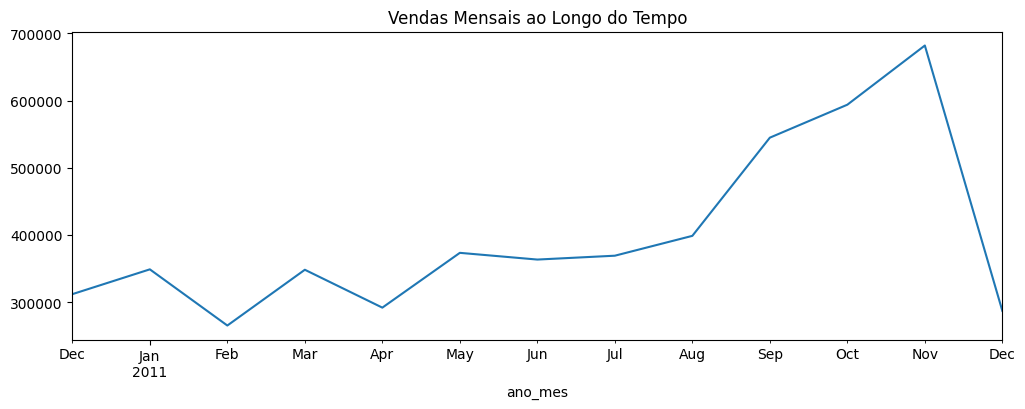

In [10]:
df['ano_mes'] = df['InvoiceDate'].dt.to_period('M')

vendas_mes = df.groupby('ano_mes')['Quantity'].sum()

vendas_mes.plot(figsize=(12,4))
plt.title('Vendas Mensais ao Longo do Tempo')
plt.show()


Observa-se que o conjunto de dados contempla transações no período de dezembro de 2010 a dezembro de 2011.

Para este projeto, optei por considerar apenas as vendas realizadas no ano de 2011, de modo a padronizar a análise em uma janela temporal completa de 12 meses. Essa delimitação garante maior consistência nos cálculos de Recência, Frequência e Valor Monetário, evitando distorções que poderiam ocorrer ao incluir períodos incompletos.

In [11]:
df = df[df['InvoiceDate'].dt.to_period('M') != '2010-12']

display(df)

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,ano_mes
42481,42481,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,1.95,13313.0,United Kingdom,19.50,2011-01
42482,42482,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.42,13313.0,United Kingdom,10.50,2011-01
42483,42483,539993,21498,RED RETROSPOT WRAP,25,2011-01-04 10:00:00,0.42,13313.0,United Kingdom,10.50,2011-01
42484,42484,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04 10:00:00,2.10,13313.0,United Kingdom,10.50,2011-01
42485,42485,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04 10:00:00,1.25,13313.0,United Kingdom,12.50,2011-01
...,...,...,...,...,...,...,...,...,...,...,...
541904,541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,2011-12
541905,541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,2011-12
541906,541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12
541907,541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12


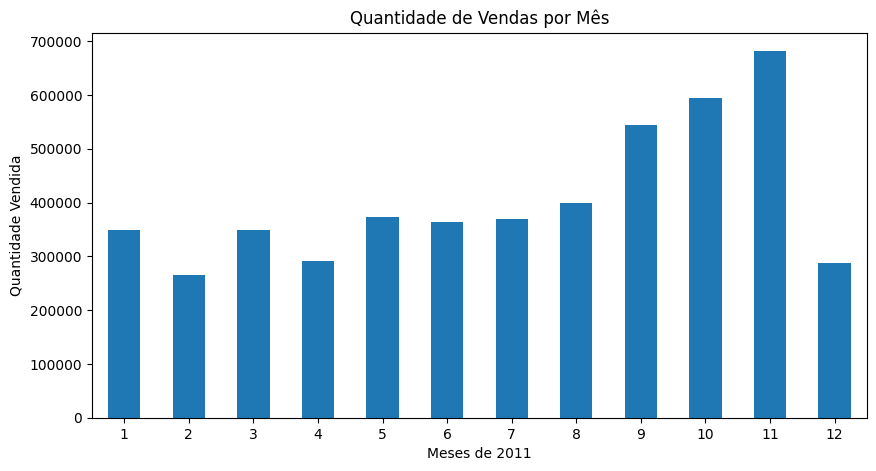

In [12]:
# Cria coluna mês
df['mes'] = df['InvoiceDate'].dt.month

# Soma as Vendas por mês
vendas_por_mes = df.groupby('mes')['Quantity'].sum()

# Gráfico
plt.figure(figsize=(10,5))
vendas_por_mes.plot(kind='bar')
plt.title('Quantidade de Vendas por Mês')
plt.xlabel('Meses de 2011')
plt.ylabel('Quantidade Vendida')
plt.xticks(rotation=0)
plt.show()

<div style="background-color: #103778; 
            color: white; 
            padding: 10px; 
            text-align: center;
            font-size: 20px;">
    <h1>2. Análise de RFM</h1>
</div>

## 2.1 Pontuação do RFM
A análise RFM é uma técnica de segmentação de clientes baseada no comportamento de compra, avaliando **Recência** (data da última compra), **Frequência** (quantidade de compras) e **Valor Monetário** (total gasto). Ela identifica os melhores clientes e os que precisam de atenção, permitindo campanhas de marketing personalizadas, maior fidelidade e aumento da receita. 

Componentes da Análise RFM:
- **Recência (R)**: Tempo decorrido desde a última compra. Clientes que compraram recentemente têm maior probabilidade de responder a novas ofertas.
- **Frequência (F)**: Número de compras realizadas em um determinado período. Compradores frequentes são mais leais e engajados.
- **Monetário (M)**: Total de dinheiro gasto pelo cliente. Clientes que gastam mais são valiosos para a receita. 

A análise RFM tem como objetivo agrupar clientes de acordo com seu comportamento de compra, avaliando quando compraram pela última vez, com que frequência compram e quanto gastam, ajudando a identificar os clientes mais relevantes para o negócio, engajados ou em risco de churn.

In [13]:
# Data da última compra
ultima_compra = df.groupby("CustomerID")["InvoiceDate"].max()

# Data de Referência
reference_date = df['InvoiceDate'].max() + dt.timedelta(days = 1)

# Criação das variáveis Recency, Frequency e MoneraryValue
recency = (reference_date - ultima_compra).dt.days
frequency = df.groupby("CustomerID")["InvoiceNo"].count()
monetary = df.groupby("CustomerID")["Total"].sum()

rfm = pd.DataFrame({
    "CustomerID": recency.index,
    "Recency": recency.values,
    "Frequency": frequency.values,
    "MonetaryValue": monetary.values 
})

#Pontuação baseada em quantis - Atribuição do rótulos de 1 a 5
#Recency
rfm["Recency Score"] = pd.qcut(rfm['Recency'], 5, labels = [5, 4, 3, 2, 1])

#Frequency score
rfm["Frequency Score"] = pd.qcut(rfm['Frequency'].rank(method = "first"), 5, labels = [1, 2, 3, 4, 5])

#Monetary score
rfm["Monetary Score"] = pd.qcut(rfm['MonetaryValue'].rank(method="first"),5, labels=[1, 2, 3, 4, 5])

display(rfm)

,CustomerID,Recency,Frequency,MonetaryValue,Recency Score,Frequency Score,Monetary Score
0,12346.0,326,1,77183.60,1,1,5
1,12347.0,2,151,3598.21,5,5,5
2,12348.0,75,14,904.44,2,1,3
3,12349.0,19,73,1757.55,4,4,4
4,12350.0,310,17,334.40,1,2,2
...,...,...,...,...,...,...,...
4215,18280.0,278,10,180.60,1,1,1
4216,18281.0,181,7,80.82,1,1,1
4217,18282.0,8,12,178.05,5,1,1
4218,18283.0,4,756,2094.88,5,5,5


In [14]:
#Combinação das pontuações de Recency, Frequency e MoneraryValue
rfm["RFM Segment"] = rfm['Recency Score'].astype(str) + rfm['Frequency Score'].astype(str) + rfm["Monetary Score"].astype(str)

# Soma das pontuções de Recency, Frequency e MoneraryValue
rfm["RFM Score"] = rfm[["Recency Score", "Frequency Score", "Monetary Score"]].sum(axis=1)

display(rfm)

,CustomerID,Recency,Frequency,MonetaryValue,Recency Score,Frequency Score,Monetary Score,RFM Segment,RFM Score
0,12346.0,326,1,77183.60,1,1,5,115,7
1,12347.0,2,151,3598.21,5,5,5,555,15
2,12348.0,75,14,904.44,2,1,3,213,6
3,12349.0,19,73,1757.55,4,4,4,444,12
4,12350.0,310,17,334.40,1,2,2,122,5
...,...,...,...,...,...,...,...,...,...
4215,18280.0,278,10,180.60,1,1,1,111,3
4216,18281.0,181,7,80.82,1,1,1,111,3
4217,18282.0,8,12,178.05,5,1,1,511,7
4218,18283.0,4,756,2094.88,5,5,5,555,15


Com as métricas de RFM estruturadas, podemos segmentar os clientes de forma estratégica, identificando grupos com comportamentos distintos e gerando insights para ações direcionadas.

Com base no RFM Score, os clientes foram segmentados em quatro níveis de valor **Bronze, Prata, Ouro e Platinum**, permitindo priorizar ações de retenção, fidelização e maximização de receita de acordo com o potencial de cada grupo. 

A categorização foi definida da seguinte forma:
- 3 a 5: Bronze
- 6 a 9: Prata
- 10 a 12: Ouro
- 13 a 15: Platinum

Essa divisão permite identificar diferentes níveis de valor e engajamento dos clientes, facilitando a definição de estratégias específicas para cada grupo.

In [15]:
#Definição dos intervalos (faixas) de classificação do RFM Score
bins = [0, 5, 9, 12, float('inf')]

#Definição dos rótulos (labels) correspondentes a cada faixa
labels = ["Bronze", "Prata", "Ouro", "Platinum"]

#Criação da coluna 'Segmento' com base na categorização do RFM Score
rfm["Segmento RFM"] = pd.cut(rfm["RFM Score"], bins=bins, labels=labels)

display(rfm)

,CustomerID,Recency,Frequency,MonetaryValue,Recency Score,Frequency Score,Monetary Score,RFM Segment,RFM Score,Segmento RFM
0,12346.0,326,1,77183.60,1,1,5,115,7,Prata
1,12347.0,2,151,3598.21,5,5,5,555,15,Platinum
2,12348.0,75,14,904.44,2,1,3,213,6,Prata
3,12349.0,19,73,1757.55,4,4,4,444,12,Ouro
4,12350.0,310,17,334.40,1,2,2,122,5,Bronze
...,...,...,...,...,...,...,...,...,...,...
4215,18280.0,278,10,180.60,1,1,1,111,3,Bronze
4216,18281.0,181,7,80.82,1,1,1,111,3,Bronze
4217,18282.0,8,12,178.05,5,1,1,511,7,Prata
4218,18283.0,4,756,2094.88,5,5,5,555,15,Platinum


In [16]:
# Criar o DataFrame com a contagem
segment_counts = rfm["Segmento RFM"].value_counts().reset_index()
segment_counts.columns = ["RFM_Segment", "Count"]

# Definir ordem hierárquica dos segmentos
ordem_segmentos = ["Bronze", "Prata", "Ouro", "Platinum"]

segment_counts["RFM_Segment"] = pd.Categorical(
    segment_counts["RFM_Segment"],
    categories=ordem_segmentos,
    ordered=True
)

# Ordenar respeitando a hierarquia definida
segment_counts = segment_counts.sort_values("RFM_Segment")

# Gráfico do RFM Segment
fig = px.bar(segment_counts,
             x="RFM_Segment",
             y="Count",
             title="Distribuição de Clientes por Segmentos do RFM",
             labels={"RFM_Segment": "Segmentos do RFM", "Count": "Número de Clientes"},
             color="RFM_Segment",
             color_discrete_sequence=px.colors.qualitative.Plotly)
fig.show()

## 2.2 Matriz de RFM
Após o cálculo das pontuações de Recência, Frequência e Valor Monetário, construiremos a Matriz RFM, que permitirá classificar e distribuir os clientes de acordo com seus padrões de comportamento de compra.

A partir dessa matriz, os clientes podem ser segmentados nos seguintes grupos:

- **VIP (13–15)**: clientes que compraram recentemente, apresentam alta frequência de compra e elevado valor monetário. Representam os clientes de maior valor para o negócio.
- **Clientes Fiéis (10–12)**: apresentam boa frequência de compra e gasto consistente, embora não estejam necessariamente entre os maiores valores monetários.
- **Fiéis em Potencial (7–9)**: clientes com compras recentes, que já realizaram mais de uma transação e demonstram potencial de aumento no valor gasto.
- **Novos Clientes (4–6)**: realizaram compras recentemente, porém ainda apresentam baixa frequência e menor valor monetário.
- **Atenção  (3)**: clientes com baixa recência (não compram há algum tempo), baixa frequência e baixo valor monetário, indicando risco de churn.

Essa segmentação permite direcionar estratégias específicas para retenção, fidelização e reativação, de acordo com o perfil comportamental de cada grupo.

In [17]:
rfm["Segmento Clientes"] = " "

rfm.loc[rfm["RFM Score"] >= 13, "Segmento Clientes"] = "VIP"
rfm.loc[(rfm["RFM Score"] >= 10) & (rfm["RFM Score"] <= 12), "Segmento Clientes"] = "Clientes Fiéis"
rfm.loc[(rfm["RFM Score"] >= 7) & (rfm["RFM Score"] <= 9), "Segmento Clientes"] = "Fiéis em Potencial"
rfm.loc[(rfm["RFM Score"] >= 4) & (rfm["RFM Score"] <= 6), "Segmento Clientes"] = "Novos Clientes"
rfm.loc[(rfm["RFM Score"] >= 2) & (rfm["RFM Score"] <= 3), "Segmento Clientes"] = "Atenção"

segment_counts = rfm["Segmento Clientes"].value_counts().sort_index()

segment_product_counts = rfm.groupby(["Segmento RFM", "Segmento Clientes"]).size().reset_index(name="Count")

segment_product_counts = segment_product_counts.sort_values("Segmento RFM", ascending=True)

fig_treemap_segment_product = px.treemap(segment_product_counts,
                                         path=["Segmento RFM", "Segmento Clientes"],
                                         values="Count",
                                         color="Segmento RFM",
                                         color_discrete_sequence=px.colors.qualitative.Plotly,
                                         title="Segmentos de Clientes RFM por Categoria")
fig_treemap_segment_product.show()

In [18]:
pastel_colors = plotly.colors.qualitative.Pastel
fig = go.Figure(data=[go.Bar(x=segment_counts.index,
                             y=segment_counts.values,
                             marker=dict(color=pastel_colors))])

#Difinindo a cor do segmento VIP
vip_color = "rgb(158, 202, 225)"
fig.update_traces(marker_color=[vip_color if segment == "VIP" else pastel_colors[i]
                                for i, segment in enumerate(segment_counts.index)],
                marker_line_color = "rgb(8, 48, 107)",
                marker_line_width = 1.5, opacity=0.6)

fig.update_layout(title="Comparando os Segmentos do RFM",
                  xaxis_title = "Segmento RFM",
                  yaxis_title = "Número de Customers",
                  showlegend = False)

fig.show()

## 2.3 Análise dos Clientes VIP

In [19]:
vip_segment = rfm[rfm["Segmento Clientes"] == "VIP"]

fig = go.Figure()
fig.add_trace(go.Box(y=vip_segment["Recency"], name="Recency"))
fig.add_trace(go.Box(y=vip_segment["Frequency"], name="Frequency"))
fig.add_trace(go.Box(y=vip_segment["MonetaryValue"], name="MonetaryValue"))
fig.update_layout(title= 'Distribuição dos Valores RFM dentro do segmento VIP', yaxis_title= 'Valor RFM', showlegend= True)  
fig.show()

In [21]:
vip_segment = rfm[rfm["Segmento Clientes"] == "VIP"]

fig = go.Figure()
fig.add_trace(go.Box(y=vip_segment["Recency Score"], name="Recency"))
fig.add_trace(go.Box(y=vip_segment["Frequency Score"], name="Frequency"))
fig.add_trace(go.Box(y=vip_segment["Monetary Score"], name="MonetaryValue"))
fig.update_layout(title= 'Distribuição dos Valores RFM dentro do segmento VIP', yaxis_title= 'Valor RFM', showlegend= True)  
fig.show()

Nestes gráficos notamos o comportamento dos clientes VIP, vemos que eles possuem o perfil de comprar com a frequência alta e altos gastos

## 2.4 Correlação entre as Pontuações RFM no Segmento VIP

In [20]:
correlation_matrix = vip_segment[["Recency Score", "Frequency Score", "Monetary Score"]].corr()

fig_heatmap = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns,
    y=correlation_matrix.columns,
    colorscale="RdBu",
    colorbar=dict(title="Correlação")
))

fig_heatmap.update_layout(title="Matriz de Correlação RFM")

fig_heatmap.show()

A correlação entre Recency Score e Frequency Score no segmento VIP apresentou valor de -0.23, indicando uma relação negativa fraca. Esse resultado sugere que, dentro desse grupo, não há uma associação forte entre frequência de compras e recência, possivelmente devido à homogeneidade do segmento ou à existência de diferentes perfis comportamentais dentro dos clientes de alto valor. Ou seja, podem existem clientes que alta frequência, mas não necessariamente comprou nos último dias ou VIPs que realizou compras recentes e de alto valor, mas que possuem frequência menor.